# Exercise 1
 <p><div class="lev1"><a href="#Task-A.-Another-LEGO-brick-in-the-wall"><span class="toc-item-num">Task A.&nbsp;&nbsp;</span>Another LEGO brick in the wall</a></div>
 <p><div class="lev1"><a href="#Task-B.-Drop-the-Bike"><span class="toc-item-num">Task B.&nbsp;&nbsp;</span>Drop the Bike</a></div>

In [1]:
# Add your imports here
# Importing pandas and numpy
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'data'

## Task A. Another LEGO brick in the wall

LEGO is a popular brand of toy building bricks. They are often sold in sets in order to build a specific object. Each set contains a number of parts in different shapes, sizes and colors. This database contains information on which parts are included in different LEGO sets. It was originally compiled to help people who owned some LEGO sets already figure out what other sets they could build with the pieces they had.

This dataset contains the official LEGO colors, parts, inventories (i.e., sets of LEGO parts which assembled create an object in the LEGO world) and sets (i.e., sets of LEGO inventories which assembled create a LEGO ecosystem). The schema of the dataset can be shown in the following UML diagram: 

![lego-schema](lego-schema.png)

In this task you have to apply the following Data Wrangling pipeline:
1. Load your data into `Pandas`
* Explore it and clean its dirty parts
* Use it to answer a set of queries

Each of these subtasks are described in detail below.

### A1. Loading phase
Load all the csv files into different `DataFrames`. Use meaningful names for your `DataFrames` (e.g., the respective filenames).

*Hint: You can load files without first unzipping them (for `Pandas` version >= 0.18.1).*

In [3]:
LEGO_DATA_FOLDER = DATA_FOLDER + '/lego'

In [4]:
# Write your code here
colors = pd.read_csv(LEGO_DATA_FOLDER + "/colors.csv.zip")
inventories = pd.read_csv(LEGO_DATA_FOLDER + "/inventories.csv.zip")
inventory_parts = pd.read_csv(LEGO_DATA_FOLDER + "/inventory_parts.csv.zip")
inventory_sets = pd.read_csv(LEGO_DATA_FOLDER + "/inventory_sets.csv.zip")
part_categories = pd.read_csv(LEGO_DATA_FOLDER + "/part_categories.csv.zip")
parts = pd.read_csv(LEGO_DATA_FOLDER + "/parts.csv.zip")
sets = pd.read_csv(LEGO_DATA_FOLDER + "/sets.csv.zip")
themes = pd.read_csv(LEGO_DATA_FOLDER + "/themes.csv.zip")

### A2. Cleaning phase
Explore the following columns from your dataset:

1. sets: year
* inventory_parts: quantity

What is the time range of the sets? 
What is the average quantity of the inventory parts? 
Do you see any inconsistencies? 
Provide code that detects and cleans such inconsistencies and validates the coherence of your dataset. 

In [5]:
# 1. Cleaning Sets: year

# Make all negative years positive
sets['year'] = sets['year'].apply(lambda x: x[1:] if x[0] == "-" else x)

# Delete last digit if year have 5 digits
sets['year'] = sets['year'].apply(lambda x: x[:-1] if len(x) == 5 else x)

# Change 70s to NAN 
sets['year'] = sets['year'].apply(lambda x: np.nan if len(x) == 3 else x)

# Change years to datetime
sets['year'] = sets['year'].apply(lambda x: pd.to_datetime(x).year)

# Check the type of sets year - should be float64
print(sets.year.dtype)




float64


In [6]:
# Calculate time range
first_year = sets.year.min()
last_year = sets.year.max()
time_range = last_year - first_year
print('The time range is ' + str(time_range) + " years, between " + str(np.int(first_year)) + " and " + str(np.int(last_year)) + ".")

The time range is 67.0 years, between 1950 and 2017.


In [7]:
# Cleaning inventory_parts: quantity
# Replace all infinite values in cells with ifinity to 0
inventory_parts.quantity = inventory_parts.quantity.replace([np.inf, -np.inf], 0.0)

# Calculate the average 
average = np.around(np.average(inventory_parts.quantity),2)

# Count amount of values equaling zero
quantity_zero = (inventory_parts['quantity'] == 0).sum()
percentage_zero = np.around(quantity_zero/inventory_parts.quantity.sum() * 100,2)

# Print results
print('The quantity average is ' + str(average) + 
'\n' + str(percentage_zero) + ' % of the values are equal to zero' )


The quantity average is 2.77
10.08 % of the values are equal to zero


__\* Briefly explain your approach here \*__

#### Cleaning sets by the column year
1. Print years to see examples of inconsistencies in the data. Examples of inconsistencies are negative years, years with five digits and years written as decade+"s"(70s, 80s, etc).
2. Cleaning:
    1. First, all negative years are turned positive.
    2. Secondly, all years with 5 digits are turned into 4 digit numbers. We assume that the last digit has been repeated and therefore remove it. For example, 20011 is turned into 2001.
    3. Lastly we changed all values to NAN where the year is written as decade+"s", as there is no way of knowing in which year of the decade the set is from.
    4. Change values to datetime
3. Calculate the time range for the sets
    
#### Cleaning inventory_parts by the column quantity
1. Print quantity to see examples of inconsistencies in the data. An example of an inconsistency is that some of the quantities are written as "-inf".
2. Cleaning:
    1. Set all quantities with the value "-inf" to 0.0 instead, as 0.0 is not used in the rest of the array. This way the data will remain but functions such as count, sum etc. can be applied to the column.
3. Calculate the average quantity
4. Calculate the percentage of zero values


### A3. Querying phase
Answer the following queries using the functionality of `Pandas`:

1. List the ids of the inventories that belong to sets that contain cars. (*Hint: Find a smart way to distinguish which sets contain cars based on the sets' name*).
* Plot the distribution of part categories as a (horizontal) bar chart. Restrict yourself to the 20 largest part categories (in terms of the number of parts belonging to the category).
* Find the dominant color of each set. Then, plot using a (horizontal) bar chart, the number of sets per dominant color. Color each bar with the respective color that it represents.
* Create a scatter plot of the *luminance*\* of the sets vs their publishing year. What do you observe for the years 1980-1981? How do you interpret what you see?

\*The luminance of a color is a [measure of brightness](https://en.wikipedia.org/wiki/Luminance) which, given its RGB representation, can be computed as follows:

$luminance = \sqrt{0.299*R^2 + 0.587*G^2 + 0.114*B^2}$

In [8]:
# Task A1
# Get sets with "car\s" in the name:
cars = r'^(?:.*\s)?cars?(?:\s.*)?$'
car_sets = sets[sets.name.str.contains(cars, flags=re.IGNORECASE)]

# Merge with inventory_sets to find the inventory ids
inventory_sets_cars = pd.merge(car_sets, inventory_sets, left_on='id', right_on='set_id')

# Drop all duplicates and make the ids into a list
cars_inventories = inventory_sets_cars.inventory_id.drop_duplicates().tolist()

# Print all ids
print('The ids of the inventories that belong to sets that contain cars  are: ' +  str(cars_inventories))



The ids of the inventories that belong to sets that contain cars  are: [13941, 10158, 13083, 5358, 13380, 8202, 16131, 1716, 10406, 14174, 7430, 14711, 12851, 10515, 14919, 2814, 15010, 5904, 7151, 11966, 8140, 6066, 1649, 6530, 14011, 2917, 6086, 1371, 13427, 528, 14493, 908, 2559, 6296, 10028, 12110, 1401, 1418, 1732, 3109, 3764, 4430, 4969, 5857, 11861, 13696, 15694, 7363, 4051, 8820, 7881, 4187, 13355, 13398, 8348, 9426, 12437, 500]


Text(0.5,1,'Distribution of parts')

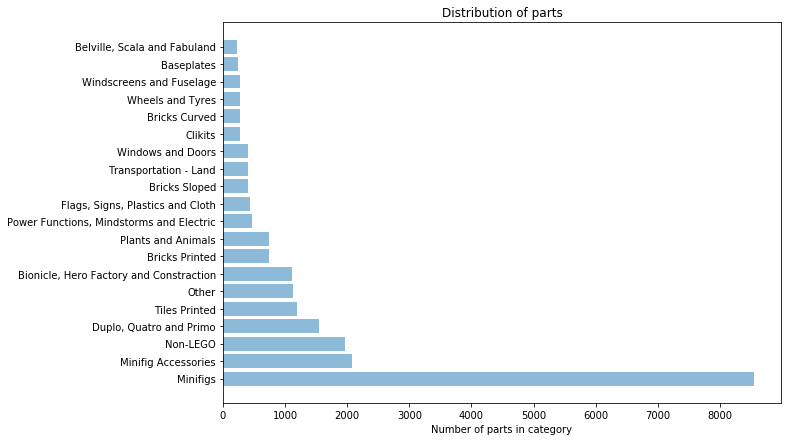

In [9]:
# Task A2 
# Count how many parts there are in each category. Select the 20 largest categories 
number_of_parts = parts.part_cat_id.value_counts().head(20)

# Join the most used parts with the part categories to get access to the part category names:
names = number_of_parts.to_frame().join(part_categories.set_index('id')).name.values

# Plot names on the y-axis and plot number of parts on the x-axis
y_pos = np.arange(len(names))
x_pos = number_of_parts.values

# Set plot variables
plt.rcParams["figure.figsize"] = [10, 7]
plt.barh(y_pos, x_pos, align='center', alpha=0.5)
plt.yticks(y_pos, names)

# Set labels for the axises
plt.xlabel('Number of parts in category')
plt.title('Distribution of parts')

In [10]:
# Task A3 - Getting the right data

# Merge inventory_sets and inventory_parts on inventory_id
# Making sure that the quantity columns are relabeled (quantity from inventory_sets 
# denotes #inventories, quantity from inventory_parts denotes #parts)
df = inventory_sets.join(inventory_parts.set_index('inventory_id'), 
                         how="left", 
                         on="inventory_id",
                         lsuffix="_inventories", 
                         rsuffix="_parts")

# Remove rows in which the number of parts are 0. (There are never any rows in which the quantity_inventories are 0)
df = df[df['quantity_parts'] != 0]

# Create a new column with the total quantity of parts by multiplying the quantity of inventories and the quantity
# of parts for a set
df['total_quantity'] = df.quantity_inventories * df.quantity_parts

# Remove unnecessary columns
df = df.drop(['inventory_id','quantity_inventories','part_id','quantity_parts','is_spare'], axis = 1).dropna()

# Small example of the data
print(df.head(2))

     set_id  color_id  total_quantity
16  10233-1    9999.0             1.0
17  88002-1    9999.0             1.0


In [11]:
# Task A3 - Calculating the dominant color for each set
def findDominantColor(data):
    color = data.groupby('color_id').total_quantity.apply(lambda y: y.sum())
    return color.idxmax()

# Create a series with the dominant color for each set
dominant_colors = df.groupby('set_id').apply(lambda set_ID: findDominantColor(set_ID))

# Count the values and join with color dataframe to get the rgb values
color_distribution = dominant_colors.value_counts().to_frame(name = 'freq')
color_distribution = colors.loc[:,['id','rgb', 'name']].set_index('id').join(color_distribution).dropna()

# Sort cells by freq 
color_distribution = color_distribution.sort_values('freq')


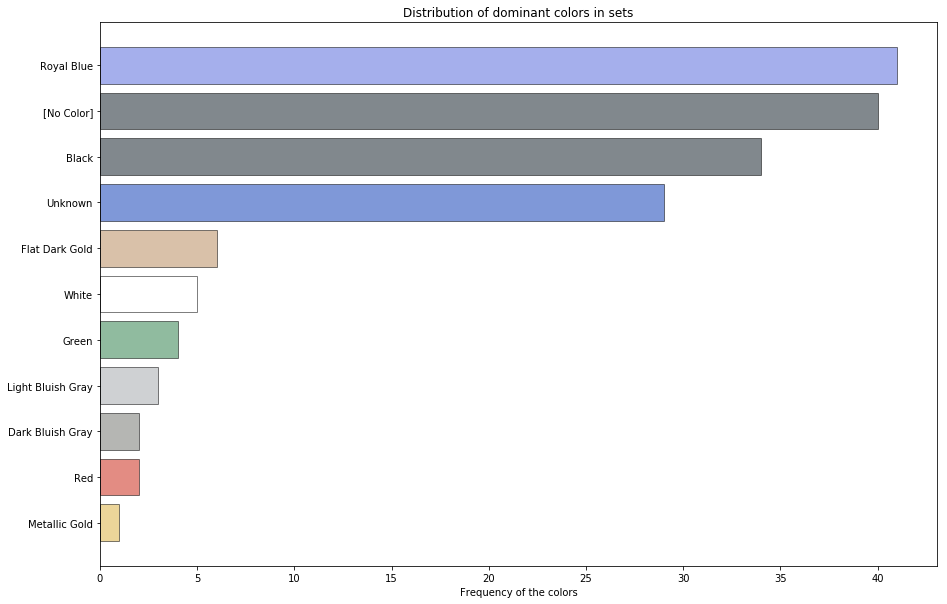

In [12]:
# Task 3 - plot

# Plot names of colors on the y-axis and the frequency of the colors on the x-axis
y = color_distribution.name
y_pos = np.arange(len(y))
x = color_distribution.freq

# Set plot parameters
plt.rcParams["figure.figsize"] = [15, 10]

# Use the rgb value to pick the colors for the bars
plt.barh(y_pos, x, align='center', alpha=0.5, color = '#' + color_distribution.rgb, edgecolor = 'black')
plt.yticks(y_pos, y)

# Set titles
plt.title('Distribution of dominant colors in sets')
plt.xlabel('Frequency of the colors')

plt.show()

In [13]:
# Make dominant_colors into a DataFrame
dominant_colors = dominant_colors.to_frame('color_id')

In [14]:
# Task A4 - Getting the right data

# Join with colors to get the rgb values
colors_clean = colors.loc[:,['id','rgb']].set_index('id')
dominant_colors_rgb = dominant_colors.reset_index().set_index('color_id').join(colors_clean).drop_duplicates()

# Join with sets to get the years
years = sets.loc[:,['id','year']]
lum_df = dominant_colors_rgb.set_index('set_id').join(years.set_index('id')).dropna()
lum_df = lum_df.loc[:, ['rgb', 'year']]


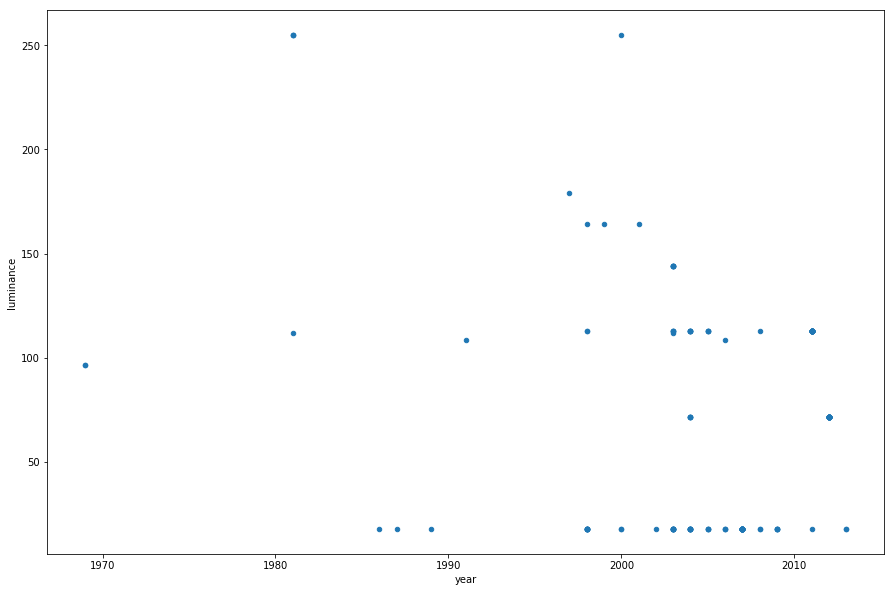

In [15]:
# Task A4 - calculate the luminance

# Import sqrt
from math import sqrt

# Function to calculate luminance from rgb
def rgb_to_lum(x):
    R, G, B = (int(x[i:i+2], 16) for i in (0, 2, 4))
    return sqrt(0.299*(R**2) + 0.587*(G**2) + 0.114*(B**2))

# Calculate the luminance based on the rgb-values
lum_df['luminance'] = lum_df['rgb'].apply(rgb_to_lum)

# Plot the luminance as a scatter plot
lum_df.plot.scatter(x='year', y='luminance')



In general the luminance is lower in the later years. In 1980-1981 the luminance isn't varied, only two different luminances are found.  


__\* Briefly explain your approach for every query here \*__

Query 1
1. Find all the sets with names including "car" or "cars" with blank space before and after. This means we obtain sets like "Shell Car Wash" even though this is not a car
2. Find the inventory ids for those sets
3. Print the list och the inventories

Query 2 
1. Count how many parts there are in each category. Select the 20 largest categories 
2. Find the category names
3. Plot the distribution of part categories

Query 3
1. Clean data and create a dataFrame with colums containing data for: set_id, color_id and total_quantity. Total_quantity is the total amount of a specific part in the specified set.
2. Find the dominant color for each set by summerizing the number of parts of the same color in the same set and then choose the color with the maximum number of parts
3. Count the number of sets that correspond to each color
4. Plot the color distrubution in a bar graph.

Query 4
1. Use the dataframe with dominant color for each set and join it with colors to get the rgb values
2. Join with sets to get the years for each set
3. Calculate the luminance for each rgb-value
4. Plot

## Task B. Drop the bike

*Los Angeles Metro* has been sharing publicly [anonymized *Metro Bike Share* trip data](https://bikeshare.metro.net/about/data/) under the [Open Database License (ODbL)](http://opendatacommons.org/licenses/odbl/1.0/).

In this task you will again perform data wrangling and interpretation.

### B1. Loading phase
Load the json file into a `DataFrame`.


In [16]:
BIKES_DATA_FOLDER = DATA_FOLDER + '/bikes'

In [17]:
# Write your code here
bikes = pd.read_json(BIKES_DATA_FOLDER + '/metro-bike-share-trip-data.json.zip')

### B2. Cleaning phase
Describe the type and the value range of each attribute. Indicate and transform the attributes that are `Categorical`. Are there redundant columns in the dataset (i.e., are there columns whose value depends only on the value of another column)? What are the possible pitfalls of having such columns? Reduce *data redundancy* by extracting such columns to separate `DataFrames`. Which of the two formats (the initial one or the one with reduced data redundancy) is more susceptible to inconsistencies? At the end print for each `Dataframe` the *type of each column* and it's *shape*.

In [18]:
# Describe type and value range
# Check min and max to get value range
bikes_max_min = bikes.describe(include=[np.number]).loc[['min','max']]
value_range = bikes_max_min.loc['max'] - bikes_max_min.loc['min']

# Print for all numerical values
[print(
    '{0:1}:\n Type: {1:1},\n Max: {2:.6f},\n Min: {3:.6f},\n Value range: {4:0.6f}'.
    format(
        i,
        str(bikes.dtypes.loc[i]),
        bikes_max_min.loc['max', i],
        bikes_max_min.loc['min', i],
        value_range[i]
    )
) for i in bikes_max_min.columns]

# Decide max and min for End Time
end_time_max = bikes['End Time'].max()
end_time_min = bikes['End Time'].min()

# Decide max and min for Start Time
start_time_max = bikes['Start Time'].max()
start_time_min = bikes['Start Time'].min()

print('End Time:\n Type: {0:1},\n Max: {1:1},\n Min: {2:1}, \n Value range between {3:1} and {4:1}'.
      format(str(bikes['End Time'].dtypes), end_time_max, end_time_min, end_time_max, end_time_min))

print('Start Time:\n Type: {0:1},\n Max: {1:1},\n Min: {2:1}, \n Value range between {3:1} and {4:1}'.
      format(str(bikes['Start Time'].dtypes), start_time_max, start_time_min, start_time_max, start_time_min))

print(('Passholder Type:\n Type: {0:1}, \n Max: does not exist,\n Min: does not exist,' +
      '\n Value can range between the following: {1:1}').
      format(str(bikes['Passholder Type'].dtypes), str(bikes['Passholder Type'].value_counts().index.tolist())))

print(('Trip Route Category Type:\n Type: {0:1}, \n Max: does not exist,\n Min: does not exist,' +
      '\n Value can range between the following: {1:1}').
      format(str(bikes['Trip Route Category'].dtypes), str(bikes['Trip Route Category'].value_counts().index.tolist())))


Bike ID:
 Type: float64,
 Max: 6728.000000,
 Min: 1349.000000,
 Value range: 5379.000000
Duration:
 Type: int64,
 Max: 86400.000000,
 Min: 60.000000,
 Value range: 86340.000000
Ending Station ID:
 Type: float64,
 Max: 4108.000000,
 Min: 3000.000000,
 Value range: 1108.000000
Ending Station Latitude:
 Type: float64,
 Max: 34.064281,
 Min: 0.000000,
 Value range: 34.064281
Ending Station Longitude:
 Type: float64,
 Max: 0.000000,
 Min: -118.472832,
 Value range: 118.472832
Plan Duration:
 Type: float64,
 Max: 365.000000,
 Min: 0.000000,
 Value range: 365.000000
Starting Station ID:
 Type: float64,
 Max: 4108.000000,
 Min: 3000.000000,
 Value range: 1108.000000
Starting Station Latitude:
 Type: float64,
 Max: 34.064281,
 Min: 0.000000,
 Value range: 34.064281
Starting Station Longitude:
 Type: float64,
 Max: 0.000000,
 Min: -118.472832,
 Value range: 118.472832
Trip ID:
 Type: int64,
 Max: 23794218.000000,
 Min: 1912818.000000,
 Value range: 21881400.000000
End Time:
 Type: object,
 Max: 

In [19]:
# The columns 'Trip Route Category' and 'Passholder Type' are objects of string characters
# which can be mapped to categories
bikes['Trip Route Category'] = bikes['Trip Route Category'].astype('category')
bikes['Passholder Type'] = bikes['Passholder Type'].astype('category')

# For 'Passholder Type', we see that 'Plan Duration' is NaN for the category 'Staff Annual'.
# Since the name is annual, we change NaN to 365
index_staff_annual = bikes[bikes['Passholder Type'].apply(lambda x: x == 'Staff Annual')].index
bikes.loc[index_staff_annual, 'Plan Duration'] = 365

# Get index for remaining nan values in category 'Monthly Pass'
index_remaining_nan = bikes[bikes['Passholder Type'].apply(lambda x: x == 'Monthly Pass') & 
                            bikes['Plan Duration'].isnull()].index

# Only 'Monthly Pass' has NaN values, change these to 30
bikes.loc[index_remaining_nan, 'Plan Duration'] = 30

# Drop all rows where latitude (if latitude is missing, so is longitude) or bike id is missing 
bikes = bikes.dropna(subset=['Ending Station Latitude', 'Starting Station Latitude', 'Bike ID'])



In [20]:
# Seperate dataframes
# Plan duration is dependent on passholder type, therefor it can be saved in a seperate df
passholder_type = bikes[['Passholder Type','Plan Duration']].drop_duplicates().reset_index(drop = True)

# We also can match the station to their latitude and longitude, which can be saved in a seperate Dataframe
# A Station ID can have two different longitudes. We round these values which make them correspond and then drop
# the duplicates. The values are sorted and the table is reindexed.
stationID = pd.concat(
    [bikes[['Ending Station ID', 'Ending Station Latitude', 'Ending Station Longitude']
          ].rename(index=str, columns={"Ending Station ID": "Station ID",
                            "Ending Station Latitude": "Latitude",
                            "Ending Station Longitude": "Longitude" }),
     bikes[['Starting Station ID', 'Starting Station Latitude', 'Starting Station Longitude']
          ].rename(index=str, columns={"Starting Station ID": "Station ID",
                            "Starting Station Latitude": "Latitude",
                            "Starting Station Longitude": "Longitude" })],
    sort=False).round(5).drop_duplicates().sort_values(by=['Station ID']).reset_index(drop=True)

In [21]:
# Other redundant columns are Duration and Trip Rooute Category
duration = bikes[['Duration']]
t_r_c = bikes[['Trip Route Category']]

In [22]:
# Drop the columns that we extracted into new dataframes
bikes = bikes.drop(['Duration', 'Plan Duration', 'Trip Route Category','Ending Station Latitude', 'Ending Station Longitude',
                    'Starting Station Latitude', 'Starting Station Longitude'], axis=1)


In [23]:
# Print all frames

# bikes
print('The datatype of each column in bikes:')
print(bikes.dtypes)
print("The shape of bikes is", bikes.shape)

# passholder type
print('\nThe datatype of each column in passholder_type:')
print(passholder_type.dtypes)
print("The shape of passholder_type is", passholder_type.shape)

# stationID
print('\nThe datatype of each column in stationID:')
print(stationID.dtypes)
print("The shape of stationID is", stationID.shape)

# duration
print('\nThe datatype of each column in duration:')
print(duration.dtypes)
print("The shape of duration is", duration.shape)

# t_r_c
print('\nThe datatype of each column in t_r_c:')
print(t_r_c.dtypes)
print("The shape of t_r_c is", t_r_c.shape)

The datatype of each column in bikes:
Bike ID                 float64
End Time                 object
Ending Station ID       float64
Passholder Type        category
Start Time               object
Starting Station ID     float64
Trip ID                   int64
dtype: object
The shape of bikes is (131327, 7)

The datatype of each column in passholder_type:
Passholder Type    category
Plan Duration       float64
dtype: object
The shape of passholder_type is (4, 2)

The datatype of each column in stationID:
Station ID    float64
Latitude      float64
Longitude     float64
dtype: object
The shape of stationID is (67, 3)

The datatype of each column in duration:
Duration    int64
dtype: object
The shape of duration is (131327, 1)

The datatype of each column in t_r_c:
Trip Route Category    category
dtype: object
The shape of t_r_c is (131327, 1)


__\* Briefly explain your approach here \*__

#### Check type and value range of each attribute
1. First check type and value range of numerical values
2. Then do it for object types

#### Categorical
1. First check which categories are based on string characters
2. Then transform these to the Category type

#### Data redundancy
1. We extract 'Plan Duration' since it's directly connected to the 'Passholder Type'
2. We extract station IDs, latitude and longitude to create a new dataframe where the IDs are matched with the longitudes
3. Other redundant columns are 'Duration' and 'Trip Route Category', since these can be calculated from other columns. These are therefore also extracted to new dataframes. (Not necessary - Only because the task description say we have to)
4. Drop the columns from bikes that are extracted into new dataframes.

Pitfalls of having redundant columns are that they take up memory space, if data is compromised in that column the entire is dirty without having to be and it is harder for a human to handle and oversee a big dataset.

The initial one is more susceptible to inconsistencies. For example, if one value of Duration has been accidentally set to an incorrect value in the first dataset it is not sure the user will notice this. If Duration is calculated based on End Time and Start Time, it will give the correct Duration between these times for each row. However this does not help if End Time or Start Time has been compromised. Another issue that might create inconsistencies for the one with reduced data redundancy is if operations are made on the extracted datasets that change their shape/size, indices etc. so the datasets no longer corresponds to the first dataset. Therefore you have to make sure the data still matches.

### B3. Querying phase
Answer the following queries using the functionality of `Pandas`.

1. Plot the *distribution* of the number of outgoing trips from each station in a histogram with 20 bins (Hint: each bin describes a range of counts, not stations).
* Plot histograms for the *duration* and *trip starting hour in the day* attributes. For both the *duration*  and the *trip starting hour* use *discrete 1-hour intervals*. What do you observe in each plot? What are some popular values in the *duration* plot? Explain the local maxima and the trends you observe on the *trip starting hour* plot based on human behavior.
* For each *trip route category*, calculate the proportion of trips by *passholder type* and present your results in *a stacked bar chart with normalized height*.
* Considering only trips that begin in the morning hours (before noon), plot in *a single bar chart* the proportion of trips by *passholder type* and *trip route category*. Explain any outliers you observe.
* Separate the hours of the day into two intervals that have (approximately) the same number of bikes leaving the stations. For each of the two intervals calculate the proportion of trips by *passholder type* and *trip route category*. Present your results in a `DataFrame` which has a unique, non-composite index. Does the proportion of trips depend on whether it is the first or second hour interval? Would the company have any significant benefit by creating a more complex paying scheme where monthly pass users would pay less in the first interval and (equally) more on the second one? Assume that the number of trips per interval will not change if the scheme changes.

Text(0.5,1,'Distribution of the number of outgoing trips')

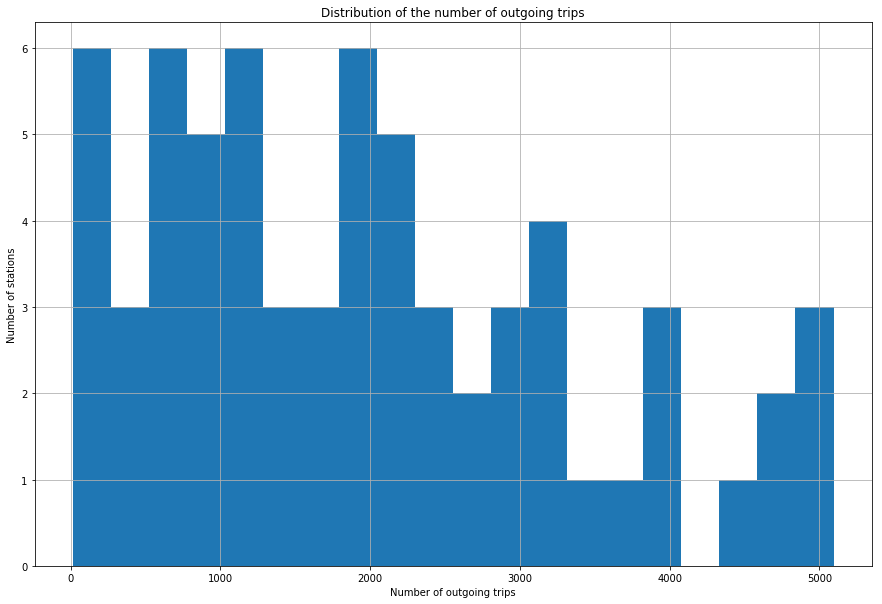

In [24]:
#Task B3.1

# Pick out the 'Starting Station ID' column and count the number of times a station has been started from.
starting_stations_count = bikes['Starting Station ID'].value_counts()

# Plot histogram
starting_stations_count.hist(bins=20)# Write your code here

# Set labels
plt.xlabel('Number of outgoing trips')
plt.ylabel('Number of stations')
plt.title('Distribution of the number of outgoing trips')

Text(0.5,1,'Distribution of Duration time')

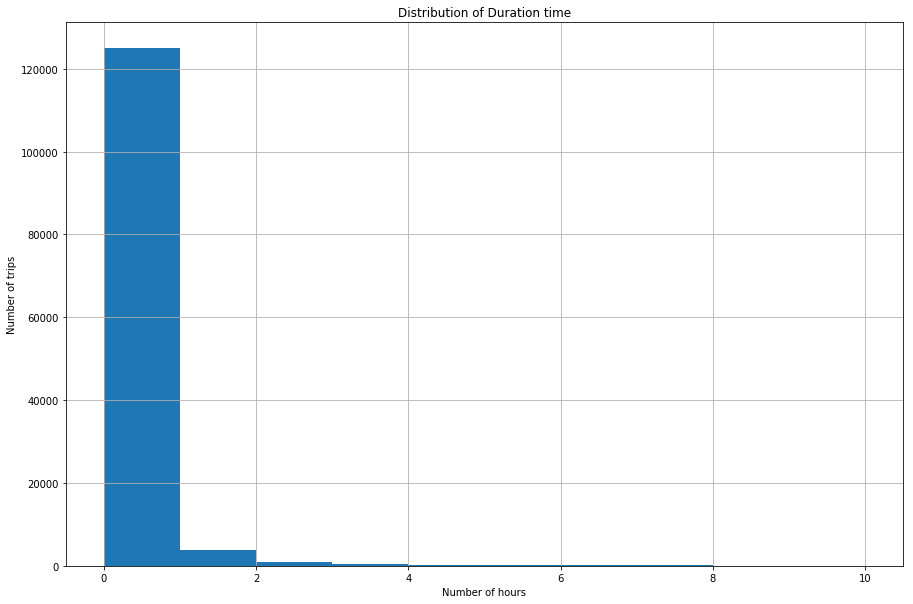

In [25]:
# Task B3.2

# Plot histograms for the duration and trip starting hour in the day attributes. 
# For both the duration and the trip starting hour use discrete 1-hour intervals. 
# What do you observe in each plot? What are some popular values in the duration plot? 
# Explain the local maxima and the trends you observe on the trip starting hour plot based on human behavior.

# Pick out duration and divide by 3660 since the durations are given in seconds.
duration = duration/3660

# Plot up to 10 hours. There are longer durations as well, but they are few, so the shape of the plot is the same.
duration.hist(bins=10, range=(0,10))

# Set labels
plt.xlabel('Number of hours')
plt.ylabel('Number of trips')
plt.title('Distribution of Duration time')

# In this plot we can see clearly that the most common amount of time to rent the bike is less than one hour.
# This makes sense, most people who use the service might be commuting to work, which for most
# people does not take more time than one hour.

Text(0.5,1,'Distribution of Start time')

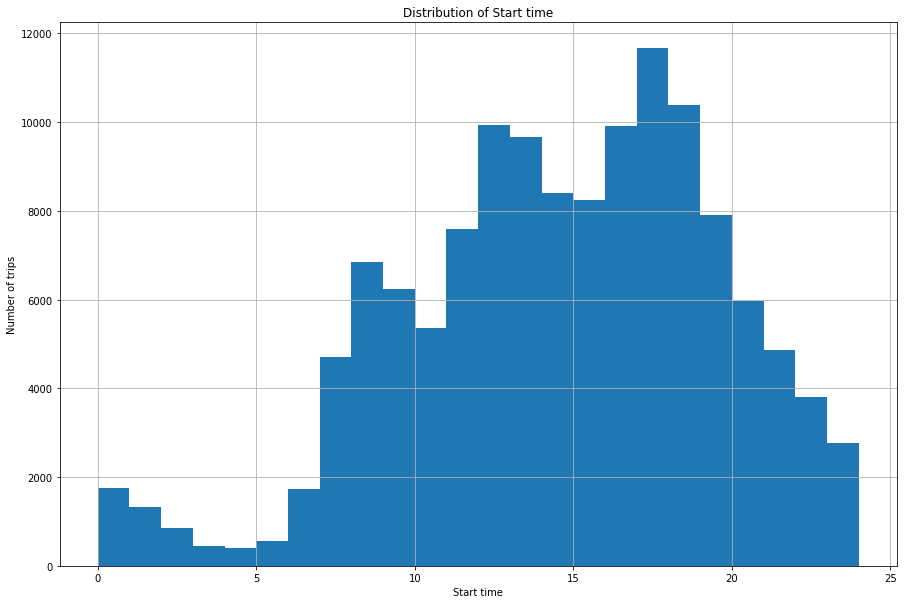

In [26]:
# Pick out Start times
trip_start = bikes['Start Time']

# Convert to datetime objects and pick out the hours.
trip_start = pd.to_datetime(trip_start).dt.hour

# Plot
trip_start.hist(bins = 24, range=(0, 24))

# Set labels
plt.xlabel('Start time')
plt.ylabel('Number of trips')
plt.title('Distribution of Start time')

# In this graph we see that the majority of the trips start some time during the day. 
# One local maxima is at around 08h00, at time when people usually go to work.
# The global maxima is in the evening around 17-18, which correspond well with the time at which people would stop
# working and go home.

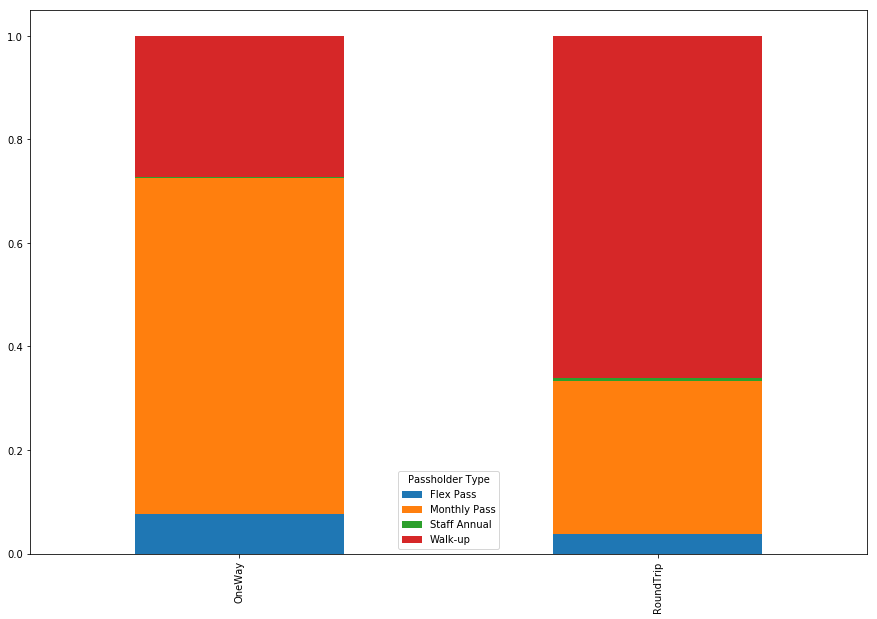

In [28]:
#Task B3.3

# For each *trip route category*, calculate the proportion of trips by 
# *passholder type* and present your results in *a stacked bar chart with normalized height*.

def trips_and_placeholder_type(df):
    """Create a dataframe with Passholder Type as the Index, and the counts of Oneway and Roundtrip for 
    the columns.
    """
    # Pick out the one way data and the round trip data separately, saving the columns for the Passholder Type
    one_way = df[df['Starting Station ID'] != df['Ending Station ID']].loc[:, 'Passholder Type']
    round_trip = df[df['Starting Station ID'] == df['Ending Station ID']].loc[:, 'Passholder Type']

    # Create new dataframe with the counts of each passholder type for one way and round trip in each column
    df2 = pd.DataFrame(dict(OneWay = one_way.value_counts(),  RoundTrip = round_trip.value_counts()))
    df2.index.name = 'Passholder Type'
    
    return df2
    
# Calculate count for each round trip for each passholder type
df2 = trips_and_placeholder_type(bikes)

# Normalize columns
df2.OneWay = df2.OneWay.div(df2.OneWay.sum())
df2.RoundTrip = df2.RoundTrip.div(df2.RoundTrip.sum())

# Transpose to plot it in the direction we want.
df2.transpose().plot.bar(stacked=True);



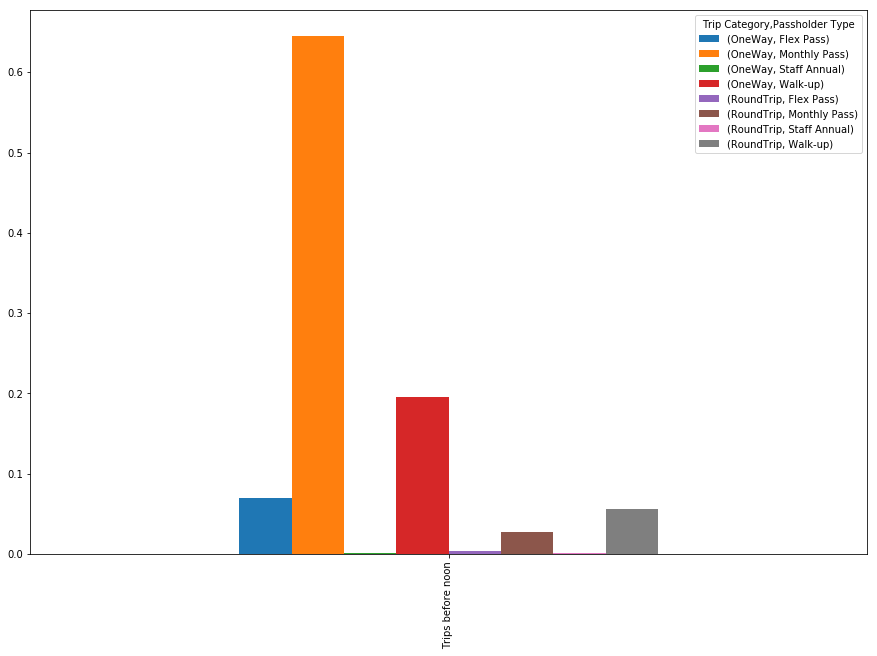

In [29]:
# Task B3.4
# Considering only trips that begin in the morning hours (before noon), 
# plot in a single bar chart the proportion of trips by passholder type and 
# trip route category. Explain any outliers you observe.

# Filter out only the trips that begin in the morning hours
trip_starting_hours = pd.to_datetime(bikes['Start Time']).dt.hour
trips_before_noon = bikes[trip_starting_hours < 12]

# Calculate count for each round trip for each passholder type
trips_before_noon = trips_and_placeholder_type(trips_before_noon)

# Unstack to put them on same single bar chart
trips_before_noon = trips_before_noon.unstack().to_frame()

# Normalize
trips_before_noon = trips_before_noon.div(trips_before_noon.sum())

# Fix labels
trips_before_noon.index = trips_before_noon.index.rename('Trip Category', level=0)
trips_before_noon.columns = ['Trips before noon']

# Transpose to plot it in the direction we want.
trips_before_noon.transpose().plot.bar();

OneWay trips are mostly performed by Monthly Pass-users. An explanation could be that Monthly Pass-users might use the bikes for commuting.


In [30]:
interval1 = bikes[trip_starting_hours <=14]
interval2 = bikes[trip_starting_hours > 14]

test = trips_and_placeholder_type(interval1).reset_index()
test

,Passholder Type,OneWay,RoundTrip
0,Flex Pass,4585,268
1,Monthly Pass,39067,2060
2,Staff Annual,130,56
3,Walk-up,15489,4185


In [35]:
# Task B3.5
# Separate the hours of the day into two intervals that have (approximately) 
# the same number of bikes leaving the stations. For each of the two intervals 
# calculate the proportion of trips by passholder type and trip route category.
# Present your results in a DataFrame which has a unique, non-composite index. 
# Does the proportion of trips depend on whether it is the first or second hour interval? 
# Would the company have any significant benefit by creating a more complex paying scheme 
# where monthly pass users would pay less in the first interval and (equally) more on the second one? 
# Assume that the number of trips per interval will not change if the scheme changes. 

# Find the hour of the division between the two intervals

# print(trip_starting_hours.median())
# gave 14, separating into hours <=14 and >14 gives approximately the same number of bikes leaving
# (66477 for <=14 and 65950 for >14)
interval1 = bikes[trip_starting_hours <=14]
interval2 = bikes[trip_starting_hours > 14]

# Calculate count for each round trip for each passholder type
interval1 = trips_and_placeholder_type(interval1)
interval2 = trips_and_placeholder_type(interval2)

# Normalize columns
interval1 = interval1.div(interval1.sum())
interval2 = interval2.div(interval2.sum())

# Unstack to get one way and round trip on the same row
interval1 = interval1.unstack().to_frame()
interval2 = interval2.unstack().to_frame()

final_df = interval1.join(interval2, lsuffix='first', rsuffix='second')

# Structure dataframe with proper column names and create non-composite index.
final_df.columns = ['First', 'Second']
index2 = [' '.join(x) for x in final_df.index.tolist()]
final_df.index = index2

# The final dataframe.
# The four values for each type of trip route category for each interval sum up to 1
print(final_df)

# The proportion of trips depend a bit on if it is in the first or the second hour interval.
# There is a larger percentage of monthly pass passholders in the first interval than in the 
# second interval (the percentages of One Way/Roundtrip monthly pass travelers are 65.7% and 31.4 % respectively
# for the first interval, compared to 63.8% and 27.4% for the second interval).
# The percentage of walk-up customers increase in the second interval.

# Since the amounts of rides are approximately the same in the two intervals, 
# we can conclude, by the percentages, that it would not be beneficial for the company to
# use the more complex paying scheme where monthly pass users pay less in the first interval 
# and more in the second (the inverse might be a good idea though).

                           First    Second
OneWay Flex Pass        0.077357  0.074036
OneWay Monthly Pass     0.659125  0.640785
OneWay Staff Annual     0.002193  0.001687
OneWay Walk-up          0.261325  0.283492
RoundTrip Flex Pass     0.040798  0.034649
RoundTrip Monthly Pass  0.313594  0.274778
RoundTrip Staff Annual  0.008525  0.003868
RoundTrip Walk-up       0.637083  0.686704


__\* Briefly explain your approach for every query here \*__